## Web scrapping using python

#### References
1. [Practical Introduction to Web Scraping in Python](https://realpython.com/python-web-scraping-practical-introduction/)
2. [Web Scraping using Python](https://www.datacamp.com/community/tutorials/web-scraping-using-python)

In [141]:
# $ python3 -m venv venv
# $ . ./venv/bin/activate

In [142]:
#Better
#!pip install requests BeautifulSoup4 fire

In [2]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import pandas as pd
import re
import os, sys

import fire

In [3]:
#%%writefile ../pyscrap_url.py

def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content  #.encode(BeautifulSoup.original_encoding)
            else:
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None


def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)


def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)
    
def get_elements(url, tag='',search={}, fname=None):
    """
    Downloads a page specified by the url parameter
    and returns a list of strings, one per tag element
    """
    
    if isinstance(url,str):
        response = simple_get(url)
    else:
        #if already it is a loaded html page
        response = url

    if response is not None:
        html = BeautifulSoup(response, 'html.parser')
        
        res = []
        if tag:    
            for li in html.select(tag):
                for name in li.text.split('\n'):
                    if len(name) > 0:
                        res.append(name.strip())
                       
                
        if search:
            soup = html            
            
            
            r = ''
            if 'find' in search.keys():
                print('findaing',search['find'])
                soup = soup.find(**search['find'])
                r = soup

                
            if 'find_all' in search.keys():
                print('findaing all of',search['find_all'])
                r = soup.find_all(**search['find_all'])
   
            if r:
                for x in list(r):
                    if len(x) > 0:
                        res.extend(x)
            
        return res

    # Raise an exception if we failed to get any data from the url
    raise Exception('Error retrieving contents at {}'.format(url))    
    
    
if get_ipython().__class__.__name__ == '__main__':
    fire(get_tag_elements)

In [4]:
res = get_elements('https://africafreak.com/100-most-influential-twitter-users-in-africa', tag = 'h2')

In [61]:
res_cleaned = []
for element in res:
    if re.findall("@", element):
        res_cleaned.append(element)
        
        
df = pd.DataFrame(res_cleaned)
df1 = df[0].str.split('@', expand = True)

influencers = df1[1].tolist()

final = []
for influencer in influencers:
    influencer = influencer.strip(')')
    final.append(influencer)
    
final[:5]

['gettleman', 'a24media', 'andiMakinana', 'AfricaCheck', 'JamesCopnall']

In [65]:
pd.DataFrame(final, columns = ['Twitter handles']).to_csv('influencers_scraped.csv', index = False, encoding = 'utf-8')

In [66]:
afr_influencers = pd.read_csv('influencers_scraped.csv')
afr_influencers.head()

,Twitter handles
0,gettleman
1,a24media
2,andiMakinana
3,AfricaCheck
4,JamesCopnall


In [12]:
afr_influencers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Twitter handles  100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [45]:
url= 'https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/#east-africa'
response = simple_get(url)

In [60]:
res_gov = get_elements(response, search={'find_all':{'class_':'twitter-tweet'}})

res_gov_cleaned = []
for element in res_gov:
    if "@" in element:
        res_gov_cleaned.append(element)

df_gov = pd.DataFrame(res_gov_cleaned)
df1_gov = df_gov[0].str.split('@', expand = True)

afr_leaders = df1_gov[1].tolist()

leaders_final = []
for leader in afr_leaders:
    leader = leader.strip()
    leader = leader.strip(')')
    leaders_final.append(leader)
    
leaders_final[:5]

findaing all of {'class_': 'twitter-tweet'}


['EswatiniGovern1', 'MalawiGovt', 'hagegeingob', 'FinanceSC', 'PresidencyZA']

In [63]:
pd.DataFrame(leaders_final, columns = ['Twitter handles']).to_csv('leaders_scraped.csv', index = False, encoding = 'utf-8')

In [64]:
afr_leaders = pd.read_csv('leaders_scraped.csv')
afr_leaders.head()

,Twitter handles
0,EswatiniGovern1
1,MalawiGovt
2,hagegeingob
3,FinanceSC
4,PresidencyZA


In [14]:
afr_leaders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Twitter handles  36 non-null     object
dtypes: object(1)
memory usage: 416.0+ bytes


## Searching and Downloading Tweets by Africa Influencers and Leaders

In [178]:
import json
import matplotlib.pyplot as plt
%matplotlib inline

import string
import seaborn as sns
sns.set()

#Import necessary methods from tweepy library
import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import Cursor
from tweepy import API

from collections import Counter

#sentiment analysis package
from textblob import TextBlob

In [1]:
 #Variables that contains the user credentials to access Twitter API 
consumer_key = '#'
consumer_secret = '#'
access_token = '#'
access_token_secret = '#'
            
#This handles Twitter authetification and the connection to Twitter Streaming API
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
            
auth_api = API(auth) 

NameError: name 'OAuthHandler' is not defined

In [199]:
def get_user_info(plist, csvfile):
    #count = 0
    users_info = []
    for user in plist:
        #if count < 2:
        print ('GETTING DATA FOR ' + user)
        try:
            item = auth_api.get_user(user)
            followers = item.followers_count
            following = item.friends_count
            reach_score = followers - following
        
            users_info.append([item.name, item.description, item.screen_name, item.created_at, item.statuses_count, following, followers, reach_score])
            
        except Exception:
            pass
        #count += 1
        
    print('Done!!')
    
    user_df = pd.DataFrame(users_info, columns = ["User", "Description", "Handle", "Creation Date", "Tweets", "Following", "Followers","Reach Score"])
    user_df.to_csv(csvfile, index = False, encoding = 'utf-8')

In [200]:
get_user_info(final, 'Influencers_info.csv')

GETTING DATA FOR @gettleman
GETTING DATA FOR @a24media
GETTING DATA FOR @andiMakinana
GETTING DATA FOR @AfricaCheck
GETTING DATA FOR @JamesCopnall
GETTING DATA FOR @oafrica
GETTING DATA FOR @PatrickNgowi
GETTING DATA FOR @StateAfrica
GETTING DATA FOR @Moadow
GETTING DATA FOR @BrendanSAfrica
GETTING DATA FOR @CityTshwane
GETTING DATA FOR @VISI_Mag
GETTING DATA FOR @andBeyondSafari
GETTING DATA FOR @ThisIsAfricaTIA
GETTING DATA FOR @sarzss
GETTING DATA FOR @TheEIU_Africa
GETTING DATA FOR @InvestInAfrica
GETTING DATA FOR @malonebarry
GETTING DATA FOR @artsouthafrica
GETTING DATA FOR @KahnMorbee
GETTING DATA FOR @JamalMOsman
GETTING DATA FOR @iamsuede
GETTING DATA FOR @mikestopforth
GETTING DATA FOR @equal_education
GETTING DATA FOR @t_mcconnell
GETTING DATA FOR @forbeesta
GETTING DATA FOR @hurricanevaness
GETTING DATA FOR @BBCKarenAllen
GETTING DATA FOR @jaxpanik
GETTING DATA FOR @thisisafrica
GETTING DATA FOR @audisouthafrica
GETTING DATA FOR @ONEinAfrica
GETTING DATA FOR @Hamza_Africa
G

In [202]:
get_user_info(leaders_final, 'leaders_info.csv')

GETTING DATA FOR @EswatiniGovern1
GETTING DATA FOR @MalawiGovt
GETTING DATA FOR @hagegeingob
GETTING DATA FOR @FinanceSC
GETTING DATA FOR @PresidencyZA
GETTING DATA FOR @mohzambia
GETTING DATA FOR @edmnangagwa
GETTING DATA FOR @MinSantedj
GETTING DATA FOR @hawelti
GETTING DATA FOR @StateHouseKenya
GETTING DATA FOR @PaulKagame
GETTING DATA FOR @M_Farmaajo
GETTING DATA FOR @SouthSudanGov
GETTING DATA FOR @SudanPMHamdok
GETTING DATA FOR @TZSpokesperson
GETTING DATA FOR @KagutaMuseveni
GETTING DATA FOR @angola_Mirex
GETTING DATA FOR @willynyamitwe
GETTING DATA FOR @Cherif_MZ
GETTING DATA FOR @Presidence_RDC
GETTING DATA FOR @PresidentABO
GETTING DATA FOR @PresidenceBenin
GETTING DATA FOR @rochkaborepf
GETTING DATA FOR @PresidenciaCV
GETTING DATA FOR @AOuattara_PRCI
GETTING DATA FOR @Presidency_GMB
GETTING DATA FOR @NAkufoAddo
GETTING DATA FOR @President_GN
GETTING DATA FOR @USEmbalo
GETTING DATA FOR @PresidenceMali
GETTING DATA FOR @CheikhGhazouani
GETTING DATA FOR @IssoufouMhm
GETTING DAT

In [36]:
reach_score_influencer = pd.DataFrame(pd.read_csv('Influencers_info.csv')).sort_values(['Reach Score'], ascending = 0)
reach_score_influencer.head()

,User,Description,Handle,Creation Date,Tweets,Following,Followers,Reach Score
87,Trevor Noah,Comedian from South Africa. I was in the crowd...,Trevornoah,2009-06-11 07:03:48,11185,325,10802044,10801719
84,News24,South Africa's premier online news resource. F...,News24,2008-05-08 07:45:58,322572,632,3574943,3574311
83,Julius Sello Malema,Commander in Chief of Economic Freedom Fighter...,Julius_S_Malema,2010-02-24 14:58:49,37190,652,3125512,3124860
86,Gareth Cliff,President of https://t.co/scMZ7lsVKF ⚜. Enquir...,GarethCliff,2008-12-08 13:20:23,31623,356,1974451,1974095
74,Euphonik™♛,LIFE | MUSIC | PROPERTY | BRANDS | CULTURE Con...,euphonik,2009-02-18 18:36:47,4516,65,1754073,1754008


In [37]:
reach_score_influencer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88 entries, 87 to 15
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User           88 non-null     object
 1   Description    85 non-null     object
 2   Handle         88 non-null     object
 3   Creation Date  88 non-null     object
 4   Tweets         88 non-null     int64 
 5   Following      88 non-null     int64 
 6   Followers      88 non-null     int64 
 7   Reach Score    88 non-null     int64 
dtypes: int64(4), object(4)
memory usage: 6.2+ KB


In [38]:
reach_score_leaders = pd.DataFrame(pd.read_csv('leaders_info.csv')).sort_values(['Reach Score'], ascending = 0)
reach_score_leaders.head()

,User,Description,Handle,Creation Date,Tweets,Following,Followers,Reach Score
30,Muhammadu Buhari,This is the official account of Muhammadu Buha...,MBuhari,2014-12-22 08:56:35,4734,26,3268374,3268348
13,Yoweri K Museveni,President of the Republic of Uganda,KagutaMuseveni,2010-03-27 15:08:09,6640,28,1809786,1809758
3,Presidency | South Africa 🇿🇦,This is the official Twitter page of The Presi...,PresidencyZA,2009-05-18 08:38:44,18845,14,1597309,1597295
24,Nana Akufo-Addo,Official Twitter account of Nana Addo Dankwa A...,NAkufoAddo,2011-02-04 10:14:22,7089,351,1504497,1504146
31,Macky Sall,Président de la République du Sénégal 🇸🇳,Macky_Sall,2010-10-01 17:05:26,2796,171,1372966,1372795


In [39]:
reach_score_leaders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 30 to 2
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User           34 non-null     object
 1   Description    32 non-null     object
 2   Handle         34 non-null     object
 3   Creation Date  34 non-null     object
 4   Tweets         34 non-null     int64 
 5   Following      34 non-null     int64 
 6   Followers      34 non-null     int64 
 7   Reach Score    34 non-null     int64 
dtypes: int64(4), object(4)
memory usage: 2.4+ KB


In [215]:
def get_tweets(nlist,csvfile1, csvfile2, csvfile3):
    hashtags = []
    mentions = []
    popular = []

    #count = 0
    tweet_count = 0
    retweet_count = 0
    likes_count = 0

    for user in nlist:
        #if count < 2:
        print ("GETTING DATA FOR "+ user)
            
        try:

            for status in Cursor(auth_api.user_timeline, id = user).items():
                    
                tweet_count +=1
    
                retweets = status.retweet_count
                retweet_count += retweets
    
                likes = status.favorite_count
                likes_count += likes
    
                if hasattr(status, "entities"):
                    entities = status.entities
                    if "hashtags" in entities:
                        for ent in entities["hashtags"]:
                            if ent is not None:
                                if "text" in ent:
                                    hashtag = ent["text"]
                                    if hashtag is not None:
                                        hashtags.append(hashtag)
                    if "user_mentions" in entities:
                        for ent in entities["user_mentions"]:
                            if ent is not None:
                                if "screen_name" in ent:
                                    name = ent["screen_name"]
                                    if name is not None:
                                        mentions.append([user, name])
        except Exception:
            pass
            
        popularity_score = retweet_count + likes_count
        popular.append([user, tweet_count, retweet_count, likes_count, popularity_score])
            
        #count += 1
    print("Done!")
    
    hashtags_df = pd.DataFrame(hashtags, columns = ["hashtags"])
    mentions_df = pd.DataFrame(mentions, columns = ["mentions"])
    popularity_df = pd.DataFrame(popular, columns = ["User", "Tweets", "Retweets", "Likes", "Popularity Score"])
    
    hashtags_df.to_csv(csvfile1, index = False, encoding = "utf-8")
    mentions_df.to_csv(csvfile2, index = False, encoding = "utf-8")
    popularity_df.to_csv(csvfile3, index = False, encoding = "utf-8")

In [216]:
get_tweets(final, "influencer_hashtags.csv", "influencer_mentions.csv", "influencer_popularity.csv")

GETTING DATA FOR @gettleman
GETTING DATA FOR @a24media
GETTING DATA FOR @andiMakinana
GETTING DATA FOR @AfricaCheck
GETTING DATA FOR @JamesCopnall
GETTING DATA FOR @oafrica
GETTING DATA FOR @PatrickNgowi
GETTING DATA FOR @StateAfrica
GETTING DATA FOR @Moadow
GETTING DATA FOR @BrendanSAfrica
GETTING DATA FOR @CityTshwane
GETTING DATA FOR @VISI_Mag
GETTING DATA FOR @andBeyondSafari
GETTING DATA FOR @ThisIsAfricaTIA
GETTING DATA FOR @sarzss
GETTING DATA FOR @TheEIU_Africa
GETTING DATA FOR @InvestInAfrica
GETTING DATA FOR @malonebarry
GETTING DATA FOR @artsouthafrica
GETTING DATA FOR @KahnMorbee
GETTING DATA FOR @JamalMOsman
GETTING DATA FOR @iamsuede
GETTING DATA FOR @mikestopforth
GETTING DATA FOR @equal_education
GETTING DATA FOR @t_mcconnell
GETTING DATA FOR @forbeesta
GETTING DATA FOR @hurricanevaness
GETTING DATA FOR @BBCKarenAllen
GETTING DATA FOR @jaxpanik
GETTING DATA FOR @thisisafrica
GETTING DATA FOR @audisouthafrica
GETTING DATA FOR @ONEinAfrica
GETTING DATA FOR @Hamza_Africa
G

In [217]:
get_tweets(leaders_final, "leader_hashtags.csv", "leader_mentions.csv", "leader_popularity.csv")

GETTING DATA FOR @EswatiniGovern1
GETTING DATA FOR @MalawiGovt
GETTING DATA FOR @hagegeingob
GETTING DATA FOR @FinanceSC
GETTING DATA FOR @PresidencyZA
GETTING DATA FOR @mohzambia
GETTING DATA FOR @edmnangagwa
GETTING DATA FOR @MinSantedj
GETTING DATA FOR @hawelti
GETTING DATA FOR @StateHouseKenya
GETTING DATA FOR @PaulKagame
GETTING DATA FOR @M_Farmaajo
GETTING DATA FOR @SouthSudanGov
GETTING DATA FOR @SudanPMHamdok
GETTING DATA FOR @TZSpokesperson
GETTING DATA FOR @KagutaMuseveni
GETTING DATA FOR @angola_Mirex
GETTING DATA FOR @willynyamitwe
GETTING DATA FOR @Cherif_MZ
GETTING DATA FOR @Presidence_RDC
GETTING DATA FOR @PresidentABO
GETTING DATA FOR @PresidenceBenin
GETTING DATA FOR @rochkaborepf
GETTING DATA FOR @PresidenciaCV
GETTING DATA FOR @AOuattara_PRCI
GETTING DATA FOR @Presidency_GMB
GETTING DATA FOR @NAkufoAddo
GETTING DATA FOR @President_GN
GETTING DATA FOR @USEmbalo
GETTING DATA FOR @PresidenceMali
GETTING DATA FOR @CheikhGhazouani
GETTING DATA FOR @IssoufouMhm
GETTING DAT

In [32]:
popularity_score_influencers = pd.DataFrame(pd.read_csv('influencer_popularity.csv')).sort_values(['Popularity Score'], ascending = 0)
popularity_score_influencers.head()

,User,Tweets,Retweets,Likes,Popularity Score
99,@Trevornoah,121228,44014204,6330687,50344891
98,@GarethCliff,120851,37756100,4211267,41967367
97,@SAPresident,117676,36749508,4017809,40767317
96,@News24,117657,36748658,4017809,40766467
95,@Julius_S_Malema,114441,36658744,3813370,40472114


In [33]:
popularity_score_leaders = pd.DataFrame(pd.read_csv('leader_popularity.csv')).sort_values(['Popularity Score'], ascending = 0)
popularity_score_leaders.head()

,User,Tweets,Retweets,Likes,Popularity Score
35,@MSPS_Togo,29263,2049636,6967660,9017296
34,@PresidentBio,29223,2049484,6967443,9016927
33,@Macky_Sall,29140,2042873,6927759,8970632
32,@MBuhari,29001,2024524,6802163,8826687
31,@IssoufouMhm,28481,1740401,5821006,7561407


In [82]:
inf = (pd.DataFrame(pd.read_csv('influencers_scraped.csv'))).values.tolist()
lead = (pd.DataFrame(pd.read_csv('leaders_scraped.csv'))).values.tolist()
inf_mentions = (pd.DataFrame(pd.read_csv('influencer_mentions.csv'))).values.tolist()
lead_mentions = (pd.DataFrame(pd.read_csv('leader_mentions.csv'))).values.tolist()

users = inf + lead
mentions = inf_mentions + lead_mentions

mentions_count = []
user_count = 0
user_type = ''

for user in users:
    if user_count < 100:
        user_type = 'influencer'
    else:
        user_type = 'leader'
        
    count = 0
    for mention in mentions:
        if user == mention :
            count += 1
            
    mentions_count.append([user, user_type, count])
    user_count += 1
    
mentions_count_df = (pd.DataFrame(mentions_count, columns = ["user", "user_type","mentions_count"])).to_csv("mentions_count.csv", index = False, encoding = "utf-8")

In [83]:
relevance_score = pd.DataFrame(pd.read_csv('mentions_count.csv')).sort_values(['mentions_count'], ascending = 0)
relevance_score.head(15)

,user,user_type,mentions_count
80,['liveamp'],influencer,562
98,['GarethCliff'],influencer,519
37,['MercedesBenz_SA'],influencer,445
52,['CityofJoburgZA'],influencer,387
96,['News24'],influencer,362
93,['mailandguardian'],influencer,345
122,['rochkaborepf'],leader,338
58,['AfricaResearch'],influencer,314
95,['Julius_S_Malema'],influencer,296
76,['_AfricanUnion'],influencer,245


In [187]:
def get_hashtags(hlist,csvfile1, csvfile2, tweets):
    hashtags = []
    users_hashtag = []
    unique_hashtags = []

    tweet_count = 0
    user_count = 0

    for user in hlist:
        
        if user_count < 100:
            user_type = 'influencer'
        else:
            user_type = 'leader'
        
        print ("GETTING DATA FOR ", user)
            
        try:

            for status in Cursor(auth_api.user_timeline, id = user).items(tweets):
                    
                tweet_count +=1
    
                if hasattr(status, "entities"):
                    entities = status.entities
                    if "hashtags" in entities:
                        for ent in entities["hashtags"]:
                            if ent is not None:
                                if "text" in ent:
                                    hashtag = ent["text"]
                                    if hashtag is not None:
                                        hashtags.append(hashtag)
                                        users_hashtag.append([hashtag, user_type])
        except Exception:
            pass
   
        user_count += 1    
        
    print("Done!")
    
    for item, count in Counter(hashtags).most_common(5):
        unique_hashtags.append([item, count])
        unique_hashtags_df = pd.DataFrame(unique_hashtags, columns = ["hashtag", "Frequency"])
        unique_hashtags_df.to_csv(csvfile2, index = False, encoding = "utf-8")
    
    users_hashtag_df = pd.DataFrame(users_hashtag, columns = ["hashtags", "user_type"])
    
    users_hashtag_df.to_csv(csvfile1, index = False, encoding = "utf-8")

In [148]:
usernames = final + leaders_final

In [149]:
get_hashtags(usernames, 'hashtags_data.csv', 'unique_hashtags', 10)

GETTING DATA FOR  gettleman
GETTING DATA FOR  a24media
GETTING DATA FOR  andiMakinana
GETTING DATA FOR  AfricaCheck
GETTING DATA FOR  JamesCopnall
GETTING DATA FOR  oafrica
GETTING DATA FOR  PatrickNgowi
GETTING DATA FOR  StateAfrica
GETTING DATA FOR  Moadow
GETTING DATA FOR  BrendanSAfrica
GETTING DATA FOR  CityTshwane
GETTING DATA FOR  VISI_Mag
GETTING DATA FOR  andBeyondSafari
GETTING DATA FOR  ThisIsAfricaTIA
GETTING DATA FOR  sarzss
GETTING DATA FOR  TheEIU_Africa
GETTING DATA FOR  InvestInAfrica
GETTING DATA FOR  malonebarry
GETTING DATA FOR  artsouthafrica
GETTING DATA FOR  KahnMorbee
GETTING DATA FOR  JamalMOsman
GETTING DATA FOR  iamsuede
GETTING DATA FOR  mikestopforth
GETTING DATA FOR  equal_education
GETTING DATA FOR  t_mcconnell
GETTING DATA FOR  forbeesta
GETTING DATA FOR  hurricanevaness
GETTING DATA FOR  BBCKarenAllen
GETTING DATA FOR  jaxpanik
GETTING DATA FOR  thisisafrica
GETTING DATA FOR  audisouthafrica
GETTING DATA FOR  ONEinAfrica
GETTING DATA FOR  Hamza_Africa
G

In [150]:
pd.read_csv('unique_hashtags.csv')

,hashtag,Frequency
0,COVID19,46
1,MandelaDay,16
2,Ramaphosa,8
3,Africa,7
4,Nigeria,6


[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Hashtags'),
 Text(0.5, 1.0, 'Bar plot for Influencers and Top Government Officials by hashtag')]

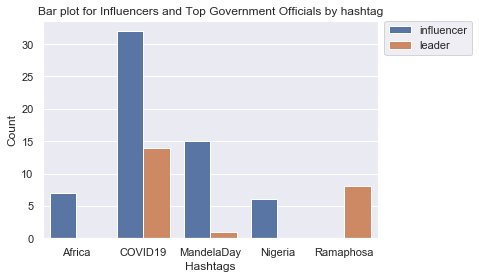

In [185]:
df = pd.DataFrame(pd.read_csv('hashtags_data.csv'))

unique_hashtags = ['COVID19', 'MandelaDay', 'Ramaphosa', 'Africa', 'Nigeria'] 
  
# selecting rows based on condition 
hashtags_grouping_data = df[df['hashtags'].isin(unique_hashtags)]

grouped = hashtags_grouping_data.groupby(['hashtags', 'user_type']).agg({'user_type': ['count']})

grouped.columns = ['count']
grouped = grouped.reset_index()

bp = sns.barplot(x = 'hashtags', y = 'count', hue = 'user_type', data = grouped)

#Position the legend out the graph
bp.legend(bbox_to_anchor=(1.02, 1),
          loc=2, 
          borderaxespad=0.0);
bp.set(title='Bar plot for Influencers and Top Government Officials by hashtag', xlabel='Hashtags', ylabel='Count')

In [ ]:
get_hashtags(usernames, 'all_hashtags_data.csv', 'all_unique_hashtags', 3200)

GETTING DATA FOR  gettleman
GETTING DATA FOR  a24media
GETTING DATA FOR  andiMakinana
GETTING DATA FOR  AfricaCheck
GETTING DATA FOR  JamesCopnall
GETTING DATA FOR  oafrica
GETTING DATA FOR  PatrickNgowi
GETTING DATA FOR  StateAfrica
GETTING DATA FOR  Moadow
GETTING DATA FOR  BrendanSAfrica
GETTING DATA FOR  CityTshwane
GETTING DATA FOR  VISI_Mag
GETTING DATA FOR  andBeyondSafari
GETTING DATA FOR  ThisIsAfricaTIA
GETTING DATA FOR  sarzss
GETTING DATA FOR  TheEIU_Africa
GETTING DATA FOR  InvestInAfrica
GETTING DATA FOR  malonebarry
GETTING DATA FOR  artsouthafrica
GETTING DATA FOR  KahnMorbee
GETTING DATA FOR  JamalMOsman
GETTING DATA FOR  iamsuede
GETTING DATA FOR  mikestopforth
GETTING DATA FOR  equal_education
GETTING DATA FOR  t_mcconnell
GETTING DATA FOR  forbeesta
GETTING DATA FOR  hurricanevaness
GETTING DATA FOR  BBCKarenAllen
GETTING DATA FOR  jaxpanik
GETTING DATA FOR  thisisafrica
GETTING DATA FOR  audisouthafrica
GETTING DATA FOR  ONEinAfrica
GETTING DATA FOR  Hamza_Africa
G

## Web scrapping using bash script
If the web site has a quite simple HTML, you can easily use curl to perform the request and then extract the needed values using bash commands grep, cut , sed, ..

This tutorial is adapted from [this](https://medium.com/@LiliSousa/web-scraping-with-bash-690e4ee7f98d) medium article

In [64]:
%%bash 

# curl the page and save content to tmp_file
#url = "https://www.atlanticcouncil.org/blogs/africasource/african-leaders-respond-to-coronavirus-on-twitter/#east-africa"
#curl -X GET $url -o tmp_file


#!/bin/bash

# write headers to CSV file
echo "Name, twitter_id" >> extractData.csv
n="1"
while [ $n -lt 2 ]
do
  
  #get title
  title=$(cat tmp_file | grep "class=\"twitter-tweet\"" | cut -d ';' -f1 )
  echo $title
  #get author
  #twitter_id=$(cat tmp_file |grep -A1 "class=\"css-901oao css-16my406 r-1qd0xha r-ad9z0x r-bcqeeo r-qvutc0\"" | tail -1)

  #echo "$title, $twitter_id" >> extractData.csv
  #echo "$title, $twitter_id"
    
  n=$[$n+1]

done

<blockquote class="twitter-tweet" data-width="550" data-dnt="true"><p lang="en" dir="ltr">The Deputy Prime Minister Themba Masuku has today met representatives of the private sector and employees&#39 <blockquote class="twitter-tweet" data-width="550" data-dnt="true"><p lang="en" dir="ltr">GUIDELINES FOR SCHOOLS IN <a href="https://twitter.com/hashtag/MALAWI?src=hash&amp <blockquote class="twitter-tweet" data-width="550" data-dnt="true"><p lang="en" dir="ltr">Fellow Namibians, I declared a State of Emergency on <a href="https://twitter.com/hashtag/COVID19?src=hash&amp <blockquote class="twitter-tweet" data-width="550" data-dnt="true"><p lang="en" dir="ltr"><a href="https://twitter.com/hashtag/COVID19measuresSC?src=hash&amp <blockquote class="twitter-tweet" data-width="550" data-dnt="true"><p lang="en" dir="ltr">The Minister for Cooperative Governance &amp <blockquote class="twitter-tweet" data-width="550" data-dnt="true"><p lang="en" dir="ltr">Join the <a href="https://twitter.com/hasht